# 批量归一化
从上往下传越靠近数据，梯度越来越小
* 损失出现在最后， 后面的层训练较快
* 数据在最底部
  * 底部的层训练较慢
  * 底部层一变化，所有都得跟着变
  * 最后的那些层需要重新学习多次
  * 导致收敛变慢
数学原理<br>
固定小批量里面的均值和方差<br>
$$\mu _B = \frac 1 {|B|} \sum _{i \in B} x_i \ and \ \sigma _B ^2 = \frac 1 {|B|} \sum _{i \in B} (x_i - \mu _B) ^2 + \epsilon$$ 
然后再做额外的调整（为可学习参数）
$$x_{i+1} = \gamma \frac {x_i - \mu_B} {\sigma_B} + \beta$$
会限制这两个参数，不让其变化过猛（$\gamma $方差，$\beta$均值）<br>
作用在
* 全连接层和卷积层输出上，激活函数前
* 全连接层和卷积层输入上
  
对于全连接层，作用在特征值(类似数据的归一化)<br>
对于卷积层，作用域通道维(一个批次像素在通道维度上归一化)<br>
人们认为归一化实际上做了一些随机的噪声（$\mu _B, \sigma _B$）<br>
控制模型复杂度<br>
批量归一化固定小批量中的均值和方差，然后学习除适合的便宜和缩放<br>
可以加速收敛速度，但一般不改变模型精度



In [3]:
import torch
from torch import nn
from d2l import torch as d2l

def batch_norm(X, gamma, beta, moving_mean, moving_var, eps, momentum):
    # moving_mean和moving_var是全局的方差，不是小批量的方差
    # momentum用于更新moving_mean和moving_var，通常取0.9

    if not torch.is_grad_enabled(): # 在评估模式下
        X_hat = (X - moving_mean) / torch.sqrt(moving_var + eps)
    else:
        assert len(X.shape) in (2, 4)
        if len(X.shape) == 2: # 全连接层在特征集中做归一化
            mean = X.mean(dim=0)
            var = ((X - mean) ** 2).mean(dim=0)
        else: # 卷积层在通道上做归一化
            mean = X.mean(dim=(0, 2, 3), keepdim=True)
            var = ((X - mean) ** 2).mean(dim=(0, 2, 3), keepdim=True)
        X_hat = (X - mean) / torch.sqrt(var + eps)
        # 信号处理中有一个概念叫做“平滑”，就是用当前值和历史值的加权平均来更新当前值
        moving_mean = momentum * moving_mean + (1 - momentum) * mean
        moving_var = momentum * moving_var + (1 - momentum) * var
    Y = gamma * X_hat + beta
    return Y, moving_mean.data, moving_var.data



定义一个batch norm层

In [4]:
class BatchNorm(nn.Module):
    def __init__(self, num_features, num_dims):
        super().__init__()
        if(num_dims == 2):
            shape = (1, num_features)
        else:
            shape = (1, num_features, 1, 1)
        # 方差
        self.gamma = nn.Parameter(torch.ones(shape))   
        # 均值
        self.beta = nn.Parameter(torch.zeros(shape))

        self.moving_mean = torch.zeros(shape)
        self.moving_var = torch.ones(shape)

    def forward(self, X):
        if self.moving_mean.device != X.device:
            self.moving_mean = self.moving_mean.to(X.device)
            self.moving_var = self.moving_var.to(X.device)
        
        Y, self.moving_mean, self.moving_var = batch_norm(X, self.gamma, self.beta,
                                                          self.moving_mean, self.moving_var,
                                                          eps=1e-5, momentum=0.9)
        return Y

将batchnorm应用在lenet上

In [5]:
net = nn.Sequential(nn.Conv2d(1, 6, kernel_size=5), 
                    BatchNorm(6, num_dims=4),nn.Sigmoid(), 
                    nn.MaxPool2d(kernel_size=2, stride=2),
                    nn.Conv2d(6, 16,kernel_size=5), 
                    BatchNorm(16, num_dims=4),nn.Sigmoid(), 
                    nn.MaxPool2d(kernel_size=2, stride=2),
                    nn.Flatten(), nn.Linear(16 * 4 * 4, 120),
                    BatchNorm(120, num_dims=2), nn.Sigmoid(),
                    nn.Linear(120, 84), BatchNorm(84, num_dims=2),
                    nn.Sigmoid(), nn.Linear(84, 10))

loss 0.238, train acc 0.915, test acc 0.881
45698.5 examples/sec on cuda:0


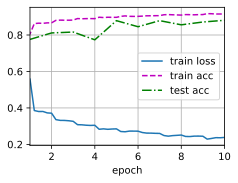

In [8]:
lr, num_epochs, batch_size = 0.5, 10, 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr,d2l.try_gpu())

可以对比[LeNet](../2_CNN/2.4_LeNet.ipynb)中的计算图，可以看到收敛的速度变快，loss降得也快<br>
接下来调用pytorch中的API

In [ ]:
net = nn.Sequential(nn.Conv2d(1, 6, kernel_size=5), nn.BatchNorm2d(6), # 输出通道数
                    nn.Sigmoid(), nn.MaxPool2d(kernel_size=2, stride=2),
                    nn.Conv2d(6, 16, kernel_size=5), nn.BatchNorm2d(16),
                    nn.Sigmoid(), nn.MaxPool2d(kernel_size=2, stride=2),
                    nn.Flatten(), nn.Linear(256, 120), nn.BatchNorm1d(120), # 输出特征数
                    nn.Sigmoid(), nn.Linear(120, 84), nn.BatchNorm1d(84),
                    nn.Sigmoid(), nn.Linear(84, 10))

loss 0.240, train acc 0.911, test acc 0.846
42244.4 examples/sec on cuda:0


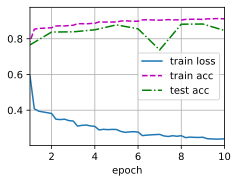

In [9]:
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

先调batchsize